# Import nessary package

In [2]:
import numpy as np
import pandas as pd
from math import sqrt

# Define cubic spline function

In [3]:
def cubic_interp1d(x0,x,y):
    
    x = np.asfarray(x)
    y = np.asfarray(y)

    if np.any(np.diff(x) < 0):
        indexes = np.argsort(x)
        x = x[indexes]
        y = y[indexes]

    size = len(x)

    xdiff = np.diff(x)
    ydiff = np.diff(y)

    # allocate buffer matrices
    Li = np.empty(size)
    Li_1 = np.empty(size-1)
    z = np.empty(size)

    # fill diagonals Li and Li-1 and solve [L][y] = [B]
    Li[0] = sqrt(2*xdiff[0])
    Li_1[0] = 0.0
    B0 = 0.0 # natural boundary
    z[0] = B0 / Li[0]

    for i in range(1, size-1, 1):
        Li_1[i] = xdiff[i-1] / Li[i-1]
        Li[i] = sqrt(2*(xdiff[i-1]+xdiff[i]) - Li_1[i-1] * Li_1[i-1])
        Bi = 6*(ydiff[i]/xdiff[i] - ydiff[i-1]/xdiff[i-1])
        z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    i = size - 1
    Li_1[i-1] = xdiff[-1] / Li[i-1]
    Li[i] = sqrt(2*xdiff[-1] - Li_1[i-1] * Li_1[i-1])
    Bi = 0.0 # natural boundary
    z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    # solve [L.T][x] = [y]
    i = size-1
    z[i] = z[i] / Li[i]
    for i in range(size-2, -1, -1):
        z[i] = (z[i] - Li_1[i-1]*z[i+1])/Li[i]

    # find index
    index = x.searchsorted(x0)
    np.clip(index, 1, size-1, index)

    xi1, xi0 = x[index], x[index-1]
    yi1, yi0 = y[index], y[index-1]
    zi1, zi0 = z[index], z[index-1]
    Mi = np.append(zi0[1:],zi1[-1])
    hi1 = xi1 - xi0

    # calculate cubic
    f0 = zi0/(6*hi1)*(xi1-x0)**3 + \
         zi1/(6*hi1)*(x0-xi0)**3 + \
         (yi1/hi1 - zi1*hi1/6)*(x0-xi0) + \
         (yi0/hi1 - zi0*hi1/6)*(xi1-x0)
    return [f0,Mi]

# load the yield data

In [4]:
data = pd.read_excel('Data.xlsx')
data.index = pd.to_datetime(data['date'])
data = data.drop(['date'],axis = 1)
data.head()

,1,3,6,12,24,36,60,84,120,240,360
date,,,,,,,,,,,
2021-12-30,0.06,0.05,0.19,0.38,0.73,0.98,1.27,1.44,1.52,1.97,1.93
2022-01-31,0.03,0.22,0.49,0.78,1.18,1.39,1.62,1.75,1.79,2.17,2.11
2022-02-28,0.06,0.35,0.69,1.01,1.44,1.62,1.71,1.81,1.83,2.25,2.17
2022-03-31,0.17,0.52,1.06,1.63,2.28,2.45,2.42,2.40,2.32,2.59,2.44
2022-04-29,0.37,0.85,1.41,2.10,2.70,2.87,2.92,2.94,2.89,3.14,2.96


# Prepare a dataframe to plot the monthly yield curve

In [5]:
df = pd.DataFrame()
df.index = np.arange(5, 361)
for i in data.index.values:
    x0 = np.arange(5, 361)
    df[i] = cubic_interp1d(x0, data.columns.values, data.loc[i].values)[0]
df

,2021-12-30,2022-01-31,2022-02-28,2022-03-31,2022-04-29,2022-05-31,2022-06-30,2022-07-29,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-30
5,0.135833,0.409100,0.594826,0.895258,1.247157,1.507839,2.280304,2.759566,3.249778,3.773337,4.499190,4.618048,4.677412
6,0.190000,0.490000,0.690000,1.060000,1.410000,1.640000,2.510000,2.910000,3.320000,3.920000,4.570000,4.700000,4.760000
7,0.237971,0.560366,0.770670,1.203407,1.559658,1.752521,2.680093,3.015198,3.373992,4.020483,4.619469,4.757351,4.812382
8,0.276689,0.618967,0.836662,1.321451,1.693500,1.844776,2.782828,3.068008,3.416556,4.076136,4.651062,4.788134,4.833360
9,0.308203,0.668017,0.890782,1.418631,1.812989,1.920208,2.832196,3.079662,3.449065,4.096938,4.667845,4.797072,4.829272
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,1.931328,2.111995,2.172661,2.444995,2.965995,3.076993,3.147993,3.006659,3.278659,3.799660,4.227327,3.806661,3.975662
357,1.930949,2.111453,2.171945,2.443700,2.964451,3.075179,3.145927,3.004919,3.276426,3.797185,4.225436,3.804939,3.974198
358,1.930600,2.110939,2.171262,2.442435,2.962937,3.073409,3.143906,3.003228,3.274237,3.794750,4.223584,3.803255,3.972767
359,1.930284,2.110454,2.170613,2.441202,2.961453,3.071682,3.141930,3.001588,3.272095,3.792354,4.221772,3.801608,3.971367


<AxesSubplot:>

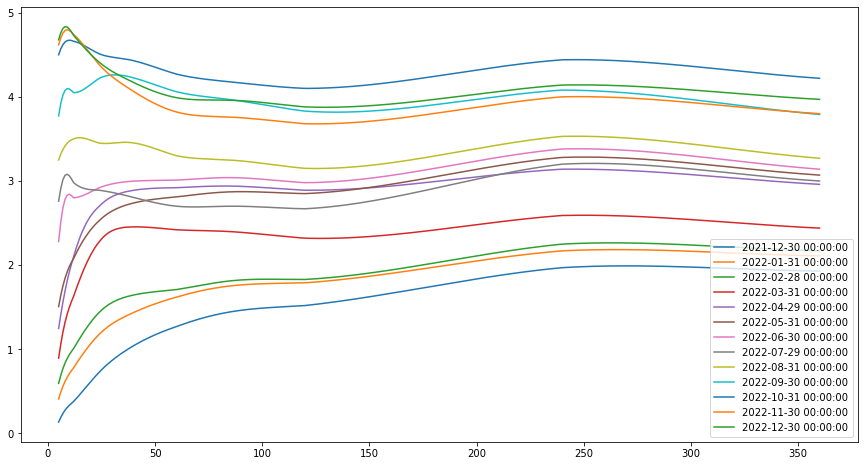

In [6]:
df.plot(figsize = (15, 8))

# $M_i$ table generate

In [7]:
M = pd.DataFrame()
for i, j in enumerate(data.index.values):
    M[i] = cubic_interp1d(data.columns.values[3:], data.columns.values[3:], data.loc[j].values[3:])[1]
M.index = data.columns.values[3:]/12
M

,0,1,2,3,4,5,6,7,8,9,10,11,12
1.0,0.001179,0.002240,0.002948,0.005659,0.005070,0.003183,0.000590,-0.000354,-0.000707,0.001651,-0.001061,-0.001297,-0.001533
2.0,-0.001042,-0.001979,-0.002604,-0.005000,-0.004479,-0.002812,-0.000521,0.000312,0.000625,-0.001458,0.000938,0.001146,0.001354
3.0,-0.000466,-0.000150,-0.000390,-0.000136,0.000073,-0.000251,-0.000355,-0.000238,-0.000980,-0.000687,-0.000564,0.000232,0.000056
5.0,-0.000204,-0.000203,0.000123,0.000065,-0.000067,-0.000036,0.000113,0.000399,0.000457,0.000380,0.000318,0.000639,0.000543
7.0,-0.000216,-0.000189,-0.000239,-0.000115,-0.000121,-0.000177,-0.000212,-0.000175,-0.000186,-0.000137,-0.000029,-0.000174,-0.000213
10.0,0.000056,0.000063,0.000086,0.000104,0.000085,0.000106,0.000126,0.000129,0.000142,0.000137,0.000110,0.000119,0.000111
20.0,-0.000064,-0.000059,-0.000069,-0.000062,-0.000061,-0.000088,-0.000090,-0.000101,-0.000092,-0.000080,-0.000079,-0.000076,-0.000064
30.0,0.000033,0.000031,0.000036,0.000033,0.000032,0.000046,0.000047,0.000053,0.000049,0.000042,0.000042,0.000040,0.000034


# Use coupncd function in excel to get the underlying coupon date then load 

In [8]:
coupon = pd.read_excel('coupon_month.xlsx')
coupon.head(10)

,A,B,C,D,E
0,2022-02-15,2022-02-15,2022-01-31,2022-01-15,2022-02-15
1,2022-08-15,2022-08-15,2022-07-31,2022-07-15,2022-08-15
2,2023-02-15,2023-02-15,2023-01-31,2023-01-15,2023-02-15
3,2023-08-15,2023-08-15,2023-07-31,2023-07-15,2023-08-15
4,2024-02-15,2024-02-15,2024-01-31,2024-01-15,2024-02-15
5,2024-08-15,2024-08-15,2024-07-31,2024-07-15,2024-08-15
6,2025-02-15,2025-02-15,2025-01-31,2025-01-15,2025-02-15
7,2025-08-15,2025-08-15,2025-07-31,NaT,2025-08-15
8,2026-02-15,2026-02-15,2026-01-31,NaT,2026-02-15
9,2026-08-15,2026-08-15,2026-07-31,NaT,2026-08-15


# Calculate the prices of these bonds

In [9]:
A_price = []
for i in data.index:
    A = pd.DataFrame()
    A.index = coupon['A'].dropna()
    A['cash'] = 4.75/2
    A.iloc[-1,0] = A.iloc[-1,0]+100

    A['m_diff'] = (A.index-pd.to_datetime(i)).days/30
    A = A[A.index>pd.to_datetime(i)]
    A['yield'] = cubic_interp1d(np.array(A['m_diff']), data.columns.values, data.loc[i].values)[0]
    A['discount'] = ((1+A['yield']/100)**(A['m_diff']/12))
    A['pv'] = A['cash']/A['discount']
    A_price.append(sum(A['pv']))

In [10]:
B_price = []
for i in data.index:
    B = pd.DataFrame()
    B.index = coupon['B'].dropna()
    B['cash'] = 1.5/2
    B.iloc[-1,0] = B.iloc[-1,0]+100

    B['m_diff'] = (B.index-pd.to_datetime(i)).days/30
    B = B[B.index>pd.to_datetime(i)]
    B['yield'] = cubic_interp1d(np.array(B['m_diff']), data.columns.values, data.loc[i].values)[0]
    B['discount'] = ((1+B['yield']/100)**(B['m_diff']/12))
    B['pv'] = B['cash']/B['discount']
    B_price.append(sum(B['pv']))

In [11]:
C_price = []
for i in data.index:
    C = pd.DataFrame()
    C.index = coupon['C'].dropna()
    C['cash'] = 3.5/2
    C.iloc[-1,0] = C.iloc[-1,0]+100

    C['m_diff'] = (C.index-pd.to_datetime(i)).days/30
    C = C[C.index>pd.to_datetime(i)]
    C['yield'] = cubic_interp1d(np.array(C['m_diff']), data.columns.values, data.loc[i].values)[0]
    C['discount'] = ((1+C['yield']/100)**(C['m_diff']/12))
    C['pv'] = C['cash']/C['discount']
    C_price.append(sum(C['pv']))

In [12]:
D_price = []
for i in data.index:
    D = pd.DataFrame()
    D.index = coupon['D'].dropna()
    D['cash'] = 1.125/2
    D.iloc[-1,0] = D.iloc[-1,0]+100

    D['m_diff'] = (D.index-pd.to_datetime(i)).days/30
    D = D[D.index>pd.to_datetime(i)]
    D['yield'] = cubic_interp1d(np.array(D['m_diff']), data.columns.values, data.loc[i].values)[0]
    D['discount'] = ((1+D['yield']/100)**(D['m_diff']/12))
    D['pv'] = D['cash']/D['discount']
    D_price.append(sum(D['pv']))

In [13]:
E_price = []
for i in data.index:
    E = pd.DataFrame()
    E.index = coupon['E'].dropna()
    E['cash'] = 3.125/2
    E.iloc[-1,0] = E.iloc[-1,0]+100

    E['m_diff'] = (E.index-pd.to_datetime(i)).days/30
    E = E[E.index>pd.to_datetime(i)]
    E['yield'] = cubic_interp1d(np.array(E['m_diff']), data.columns.values, data.loc[i].values)[0]
    E['discount'] = ((1+E['yield']/100)**(E['m_diff']/12))
    E['pv'] = E['cash']/E['discount']
    E_price.append(sum(E['pv']))

# gather the price data and put them in one table

In [14]:
price = pd.DataFrame(columns = data.index)

price.loc['A'] = A_price
price.loc['B'] = B_price
price.loc['C'] = C_price
price.loc['D'] = D_price
price.loc['E'] = E_price

price

date,2021-12-30,2022-01-31,2022-02-28,2022-03-31,2022-04-29,2022-05-31,2022-06-30,2022-07-29,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-30
A,148.119533,144.039314,140.548038,133.680546,124.570196,123.584618,122.172893,125.898237,118.050611,109.928023,105.939909,112.084600,110.378327
B,100.640696,98.570922,97.531999,93.771617,90.271698,90.896697,90.053416,92.380060,88.464686,84.481506,83.530500,86.122480,85.266140
C,113.831619,110.235915,109.972141,106.380593,103.776356,104.555390,103.792484,105.679537,101.227518,97.896408,97.236456,99.543325,99.073942
D,100.871650,99.251351,98.732752,96.650992,95.804847,96.479177,95.968089,95.874009,94.836446,93.426266,93.294659,93.933249,94.153285
E,123.023206,119.090545,116.246724,109.915407,100.925671,99.426851,98.073642,101.215607,94.688473,87.107882,82.934533,88.710792,87.062419


# add bond return into the table

In [15]:
cubic_summary = price.T

cubic_summary['A return'] = cubic_summary['A'].pct_change()
cubic_summary['B return'] = cubic_summary['B'].pct_change()
cubic_summary['C return'] = cubic_summary['C'].pct_change()
cubic_summary['D return'] = cubic_summary['D'].pct_change()
cubic_summary['E return'] = cubic_summary['E'].pct_change()
cubic_summary

,A,B,C,D,E,A return,B return,C return,D return,E return
date,,,,,,,,,,
2021-12-30,148.119533,100.640696,113.831619,100.871650,123.023206,NaN,NaN,NaN,NaN,NaN
2022-01-31,144.039314,98.570922,110.235915,99.251351,119.090545,-0.027547,-0.020566,-0.031588,-0.016063,-0.031967
2022-02-28,140.548038,97.531999,109.972141,98.732752,116.246724,-0.024238,-0.010540,-0.002393,-0.005225,-0.023879
2022-03-31,133.680546,93.771617,106.380593,96.650992,109.915407,-0.048862,-0.038555,-0.032659,-0.021085,-0.054464
2022-04-29,124.570196,90.271698,103.776356,95.804847,100.925671,-0.068150,-0.037324,-0.024480,-0.008755,-0.081788
2022-05-31,123.584618,90.896697,104.555390,96.479177,99.426851,-0.007912,0.006924,0.007507,0.007039,-0.014851
2022-06-30,122.172893,90.053416,103.792484,95.968089,98.073642,-0.011423,-0.009277,-0.007297,-0.005297,-0.013610
2022-07-29,125.898237,92.380060,105.679537,95.874009,101.215607,0.030492,0.025836,0.018181,-0.000980,0.032037
2022-08-31,118.050611,88.464686,101.227518,94.836446,94.688473,-0.062333,-0.042383,-0.042128,-0.010822,-0.064487


# Use Nelson-Siegel Model to calculate the yield and the price

<AxesSubplot:xlabel='date'>

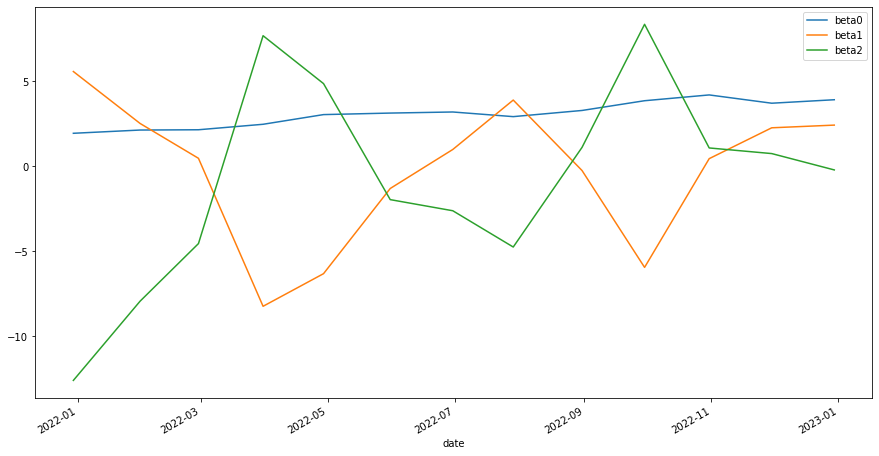

In [16]:
from sklearn.linear_model import LinearRegression
import math

bond_data = data

def get_beta(data):
    # Form X matrix
    X = []
    lambda_value = 2.5
    for maturity in data['Maturity'].values:
        x1 = (1-math.exp(-lambda_value * maturity)) / (lambda_value * maturity)
        x2 = x1 - math.exp(-lambda_value * maturity)
        x_mat = [x1, x2]
        X.append(x_mat)
    
    # Form y matrix
    y = data['YTM'].values
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    intercept, beta1, beta2 = model.intercept_, model.coef_[0], model.coef_[1]
    return intercept, beta1, beta2

# Create beta table
beta0_list = []
beta1_list = []
beta2_list = []
for bond_idx in range(bond_data.shape[0]):
    today_date = bond_data.index[bond_idx]
    maturity = [1, 2, 3, 5, 7, 10, 20, 30]
    ytm = bond_data.iloc[bond_idx].values[3:]
    beta0, beta1, beta2 = get_beta(pd.DataFrame({'Maturity': maturity, 'YTM': ytm}))
    beta0_list.append(beta0)
    beta1_list.append(beta1)
    beta2_list.append(beta2)

beta_table = pd.DataFrame(index = bond_data.index)
#{'beta0': beta0_list, 'beta1': beta1_list, 'beta2': beta2_list}, 
beta_table['beta0'] = beta0_list
beta_table['beta1'] = beta1_list
beta_table['beta2'] = beta2_list
beta_table.plot(figsize = (15, 8))

# show estimated beta

In [17]:
print(beta_table)

               beta0     beta1      beta2
date                                     
2021-12-30  1.936316  5.569771 -12.602851
2022-01-31  2.127092  2.514876  -7.942395
2022-02-28  2.144015  0.464901  -4.553874
2022-03-31  2.466274 -8.242366   7.677257
2022-04-29  3.035798 -6.323416   4.858853
2022-05-31  3.125717 -1.310997  -1.967039
2022-06-30  3.189411  0.983290  -2.620964
2022-07-29  2.916354  3.891403  -4.755419
2022-08-31  3.279254 -0.255211   1.107196
2022-09-30  3.852246 -5.952510   8.347207
2022-10-31  4.193236  0.443923   1.073358
2022-11-30  3.705764  2.259495   0.742225
2022-12-30  3.910154  2.417321  -0.219358
